## 应用: 手写数字识别



手写数字的识别问题本身涉及：数字分割和数字识别。

这里只处理后者，也就是说每个数字已经从图像中分割开了。

#### 加载和可视化手写数字数据集


### 1、从文件加载数据

In [38]:
import scipy.io as scio
from sklearn.utils import Bunch

digits = Bunch()

mat = scio.loadmat('./digits.mat')
digits.images = mat['data']
digits.target = mat['target'][0]
digits.data = digits.images.reshape((digits.images.shape[0],-1))
digits.images.shape, digits.target.shape, digits.data.shape

((1797, 8, 8), (1797,), (1797, 64))

### 2、用函数加载数据

In [34]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.images.shape, digits.target.shape, digits.data.shape

((1797, 8, 8), (1797,), (1797, 64))

数据集是三维的: 1797 个样本，每个数字由 8×8 的像素表示。

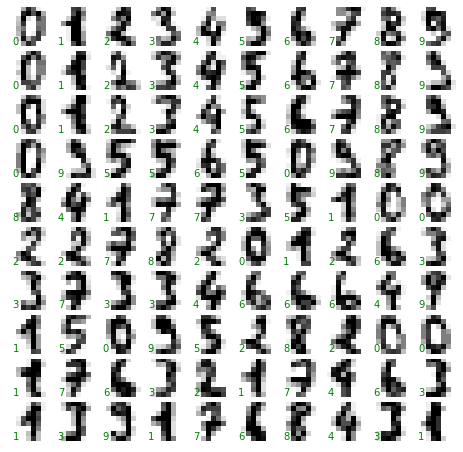

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]), transform=ax.transAxes, color='green')

- 只看一个字

Text(0.05, 0.05, '2')

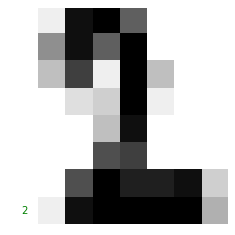

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(4,4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

ax.imshow(digits.images[1111], cmap='binary', interpolation='nearest')
ax.text(0.05, 0.05, str(digits.target[1111]), transform=ax.transAxes, color='green')

- 对于 Scikit-Learn, 我们需要将数据集表示成二维矩阵形式 ``[n_samples, n_features]``。


- 每个数字图像对应一行，即用若干个特征表示它。我们将每张图 $8\times8$ 矩阵按行存放，转化为一个 64 个数表示的向量。最后整个数据集用一个 $1797\times 64$ 的特征矩阵表示。


- 数字对应的像素值和标签对应数据集的 ``data`` 和 ``target`` 成员。

In [40]:
X = digits.data
X.shape

(1797, 64)

In [41]:
y = digits.target
y.shape

(1797,)

1797 行 64 列，表示 1797 个数字每个数字对应一个 64 维的特征向量。

### 非监督学习: 降维

现在每个样本有 64 维，不适合可视化，需要降维。
我们用非监督方法，流形学习中的算法 *Isomap*，将它降到 2 维。

In [42]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=2)

iso.fit(digits.data)

data_projected = iso.transform(digits.data)

D:\anaconda3003\envs\pytorch19\lib\site-packages\sklearn\manifold\_isomap.py:302: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\anaconda3003\envs\pytorch19\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [43]:
# 查看降维后的维度
data_projected.shape

(1797, 2)

降维以后可以可视化啦。

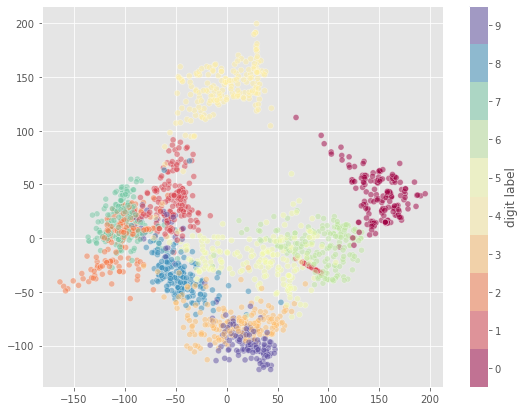

In [44]:
plt.figure(figsize=(9,7))
# 绘制降维后的二维数据
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='white', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))

plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

上图可以看出，通过降维后的 2 维坐标大致将数字分开了，比如 `8` 和 `0` 都分开了。

说明使用简单的无监督分类应该也能取得较好的预测能力。

### 数字分类

跟前面一样，将数据集分割成训练集和测试集，再用高斯朴素贝叶斯模型:

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [47]:
from sklearn.naive_bayes import GaussianNB

# 三部曲
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

查看测试集的准确率：

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

该简单模型得到 80% 左右的准确率。下面看看每个数字被误判的情况，这里我们计算一个混淆矩阵：

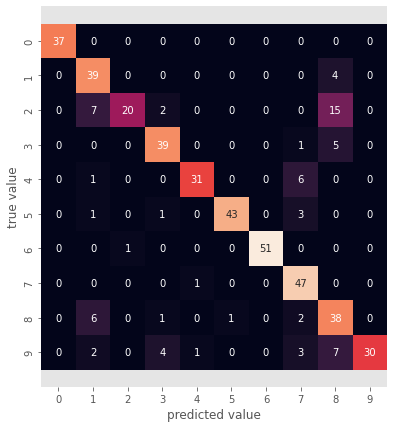

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

plt.figure(figsize=(9, 7))
ax = sns.heatmap(mat, square=True, annot=True, cbar=False)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('predicted value')
plt.ylabel('true value');

上图可以看出每个数字被误判成其他数字的情况。

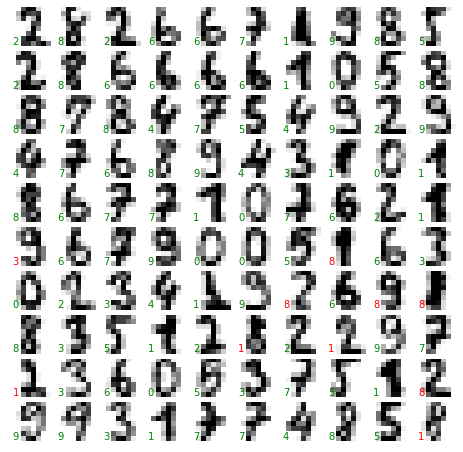

In [50]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')

从这部分数字大概可以看出哪些情况识别的不好。

为了提高准确率，可以采用更复杂的算法，如支持向量机，随机森林或者卷积神经网络。

## 小结

通用的数据表示：

   - 特征矩阵 X [n_samples, n_features]
   
   
   - 标签向量 y

通用的处理流程：
   
   - 导入（import）某类模型
   
   
   - 实例化模型，设定模型的超参数
   
   
   - 拟合（fit）数据
   
   
   - 预测（predict 或者 transform）